# Import FloorplantoBlenderlib

In [1]:
# Add outer folder 
import sys
sys.path.append("..") # Adds higher directory to python modules path.

# Import library
from FloorplanToBlenderLib import *

# Other necessary libraries
import cv2 # for image gathering
import numpy as np

# for visualize
from PIL import Image
from IPython.display import display


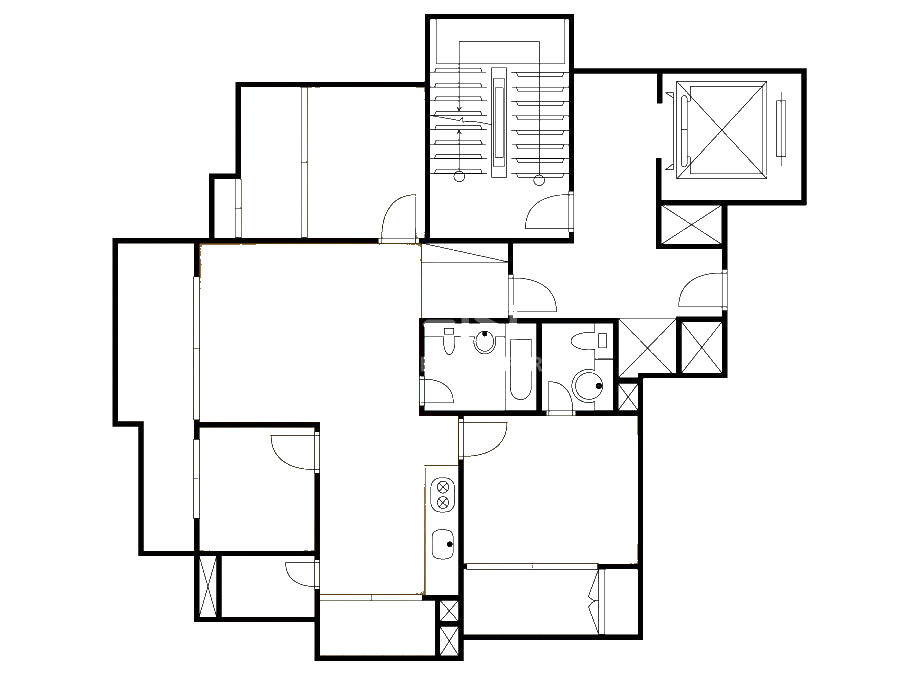

In [2]:
# 이미지 읽기
img_path = "Images/Test_img/OCR_img.png"
img = cv2.imread(img_path)

# lower_bound = np.array([0, 0, 0], dtype=np.uint8)
# upper_bound = np.array([120, 120, 120], dtype=np.uint8)
# mask = cv2.inRange(img, lower_bound, upper_bound)
# img[np.where(mask == 0)] = [255, 255, 255]
# # Display
display(Image.fromarray(img))

# Detect Contours

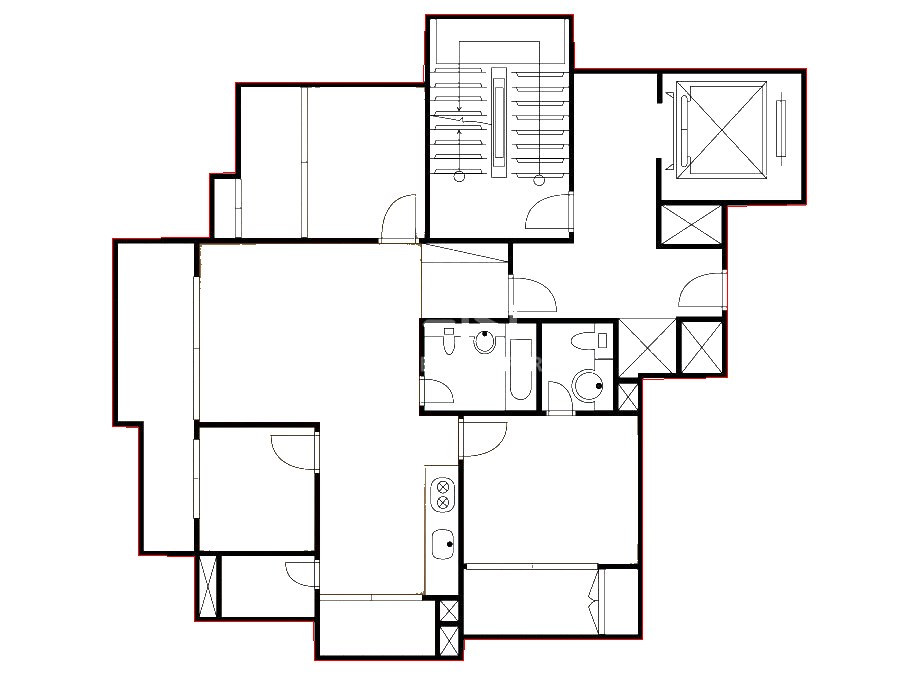

In [3]:
# # img_path = "Images/Examples/example.png"
# img_path = "Images/Test_img/Test_img1.jpg"

# # Read floorplan image
# img = cv2.imread(img_path)

# Create blank image
height, width, channels = img.shape
blank_image = img.copy()

# Grayscale image
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# detect outer Contours (simple floor or roof solution), paint them red on blank_image
contour, c_img = detect.outer_contours(gray, blank_image, color=(255,0,0))

# Display
display(Image.fromarray(blank_image))

# Detect Walls

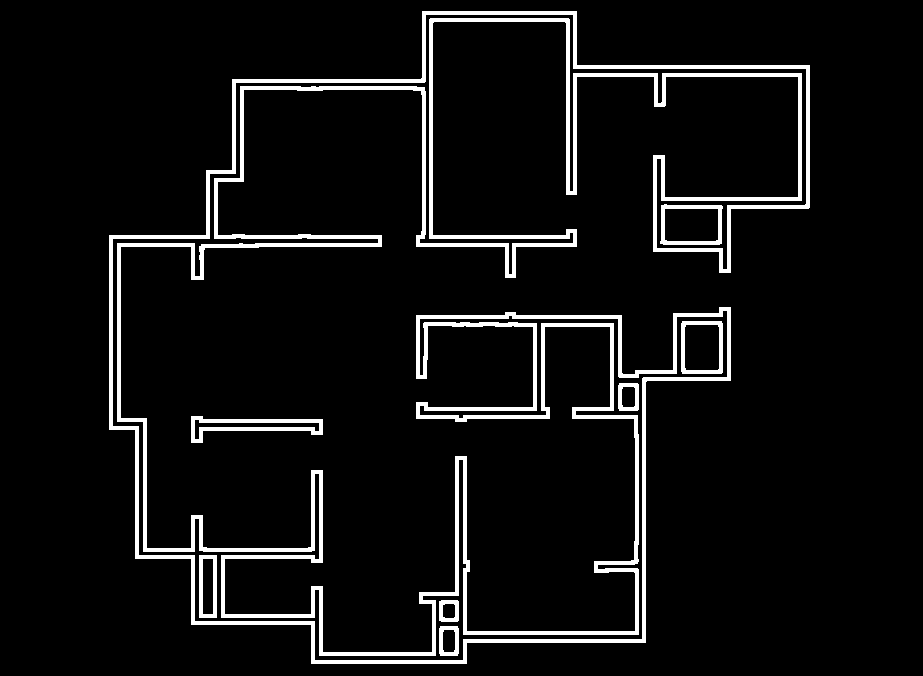

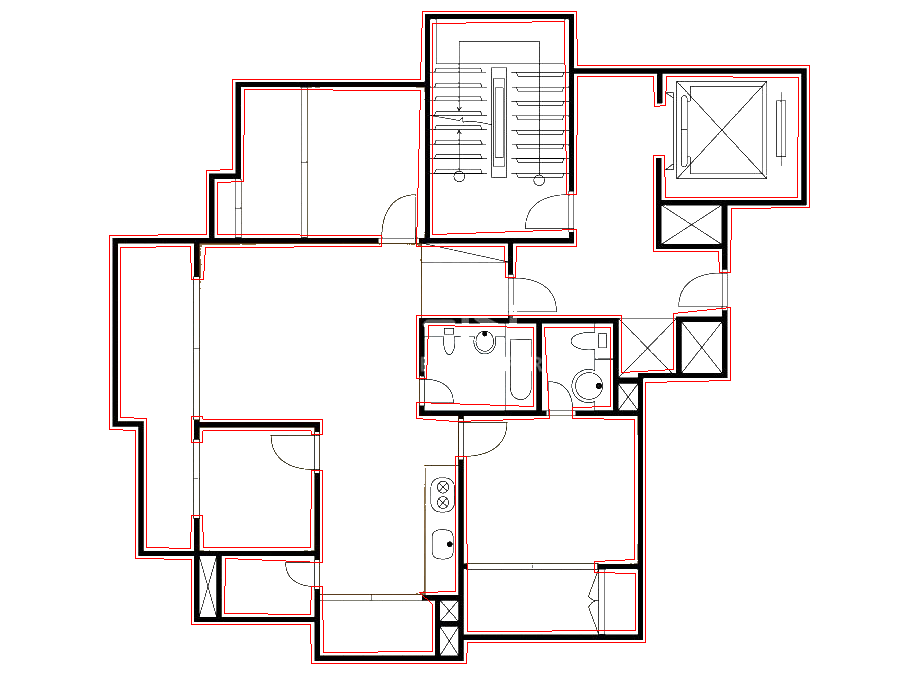

In [4]:
# Create new blank image
blank_image = img.copy()

# Perform filter on grayscaled input image
wall_img = detect.wall_filter(gray)
display(Image.fromarray(wall_img))
"""
Detect Wall
"""
boxes, w_img = detect.precise_boxes(wall_img, blank_image, color=[255,0,0])

# Display
display(Image.fromarray(blank_image))

# Detect Rooms

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


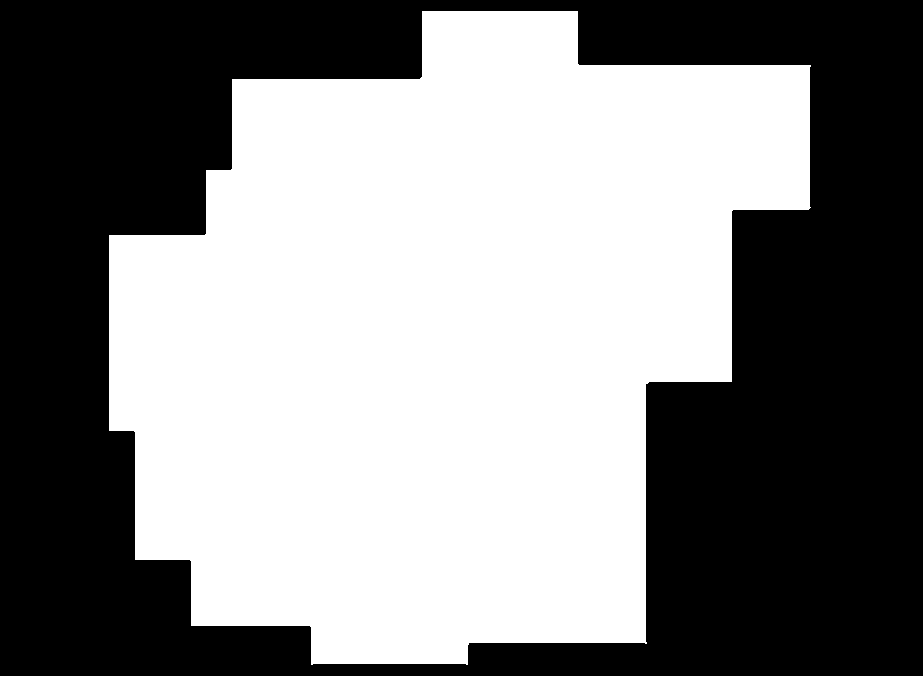

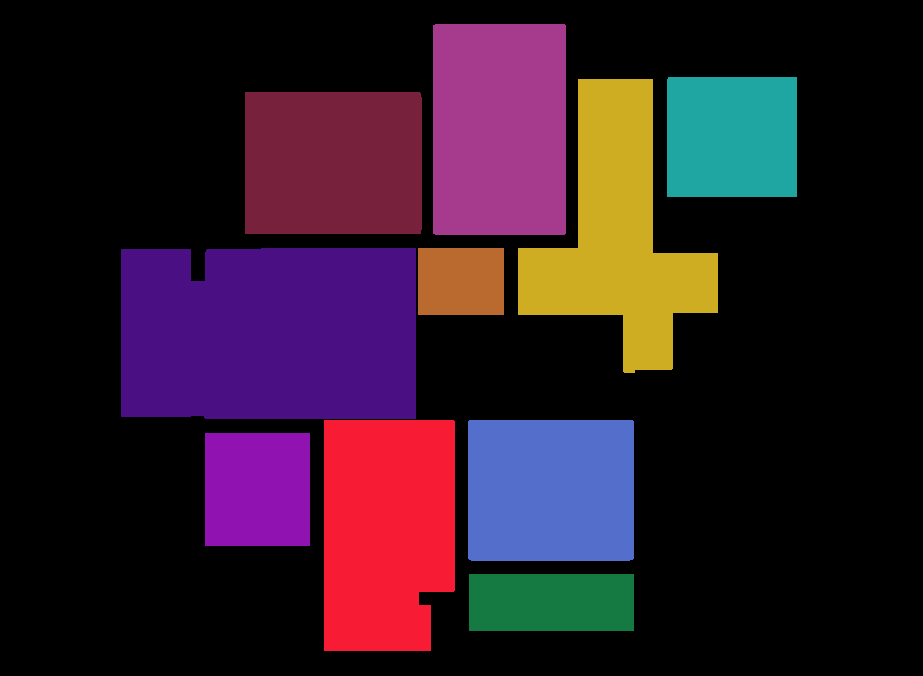

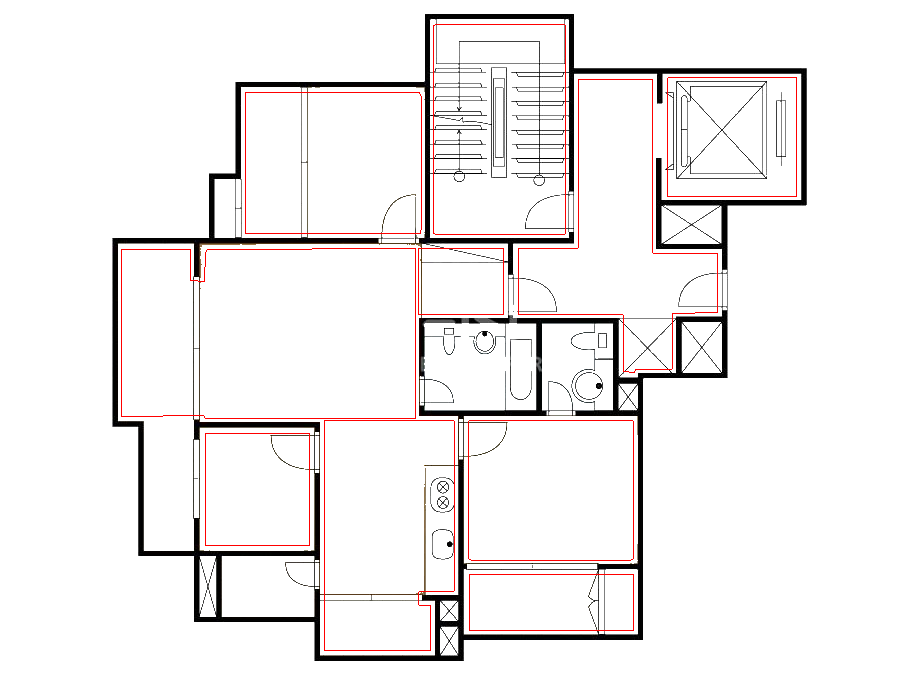

In [7]:
import FloorplanToBlenderLib.detect as detect
# Create new blank image
blank_image = img.copy()

gray = ~wall_img

# Find rooms
rooms, colored_rooms, mask = detect.find_rooms(gray)
print(mask)
display(Image.fromarray(mask))
display(Image.fromarray(colored_rooms))

gray_rooms = cv2.cvtColor(colored_rooms, cv2.COLOR_BGR2GRAY)

boxes, blank_image = detect.precise_boxes(
    gray_rooms, blank_image, color=(255, 0, 0)
)

# Display
display(Image.fromarray(blank_image))

In [8]:
import cv2
import numpy as np

def find_pattern(main_image, template):
    # SIFT 기반의 특징 추출기 생성
    sift = cv2.SIFT_create()

    # 각 이미지에서 키포인트와 디스크립터 추출
    keypoints1, descriptors1 = sift.detectAndCompute(main_image, None)
    keypoints2, descriptors2 = sift.detectAndCompute(template, None)

    # FLANN 매처 생성
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)  # 검사할 트리 수

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # 두 이미지 간의 특징 매칭 수행
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    # 좋은 매치점 필터링
    good_points = []
    for m, n in matches:
        if m.distance < 0.6 * n.distance:
            good_points.append(m)

    # 템플릿 이미지의 위치 찾기
    if len(good_points) > 10:
        query_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_points]).reshape(-1, 1, 2)
        train_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_points]).reshape(-1, 1, 2)

        matrix, mask = cv2.findHomography(query_pts, train_pts, cv2.RANSAC, 5.0)
        matches_mask = mask.ravel().tolist()

        # 투시 변환으로 문양의 경계를 찾습니다.
        h, w = template.shape
        pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
        dst = cv2.perspectiveTransform(pts, matrix)

        # 메인 이미지에 문양의 사각형 경계를 그립니다.
        main_image = cv2.polylines(main_image, [np.int32(dst)], True, (0, 255, 0), 3)

        cv2.imshow("Pattern Found", main_image)
        cv2.waitKey(0)
    else:
        print("Not enough matches are found - %d/%d" % (len(good_points), 10))


test_img = img.copy()

main_image = test_img
template = cv2.imread('Images/Models/Doors/door_4.png', cv2.IMREAD_GRAYSCALE)
find_pattern(main_image, template)


AttributeError: module 'cv2.cv2' has no attribute 'SIFT_create'

# Detect Windows & Doors

## Detect Details

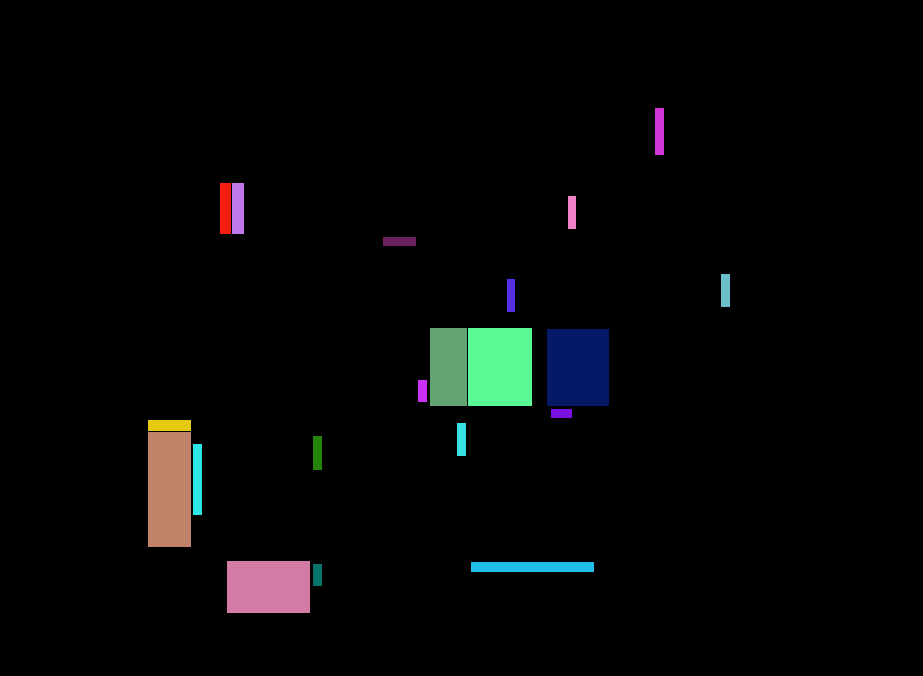

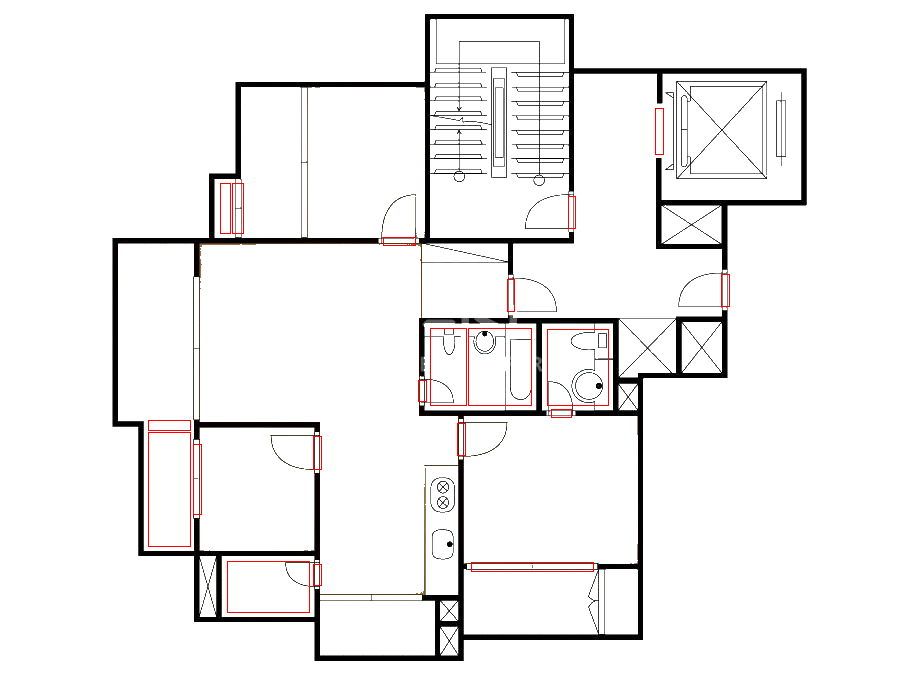

In [18]:
# Create new blank image
blank_image = img.copy()

doors, colored_doors = detect.find_details(gray.copy())
display(Image.fromarray(colored_doors))
gray_details = cv2.cvtColor(colored_doors, cv2.COLOR_BGR2GRAY)
boxes, blank_image = detect.precise_boxes(
    gray_details, blank_image, color=(255, 0, 0)
)

# Display
display(Image.fromarray(blank_image))

## Detect Doors

The door detection uses ORB feature extraction. See below how features relate between the door model and the floorplan. Additional calculations are needed to also place the doors at correct position, rotation and scale. We use five points per door to get an OK accuracy.

The code for this example can be found in `Development Center/FloorplanLibDemo/find_windows_and_doors.py`.

![door_feature](Images/Demos/door_feature_extraction.PNG)

## Detect windows

The final step of the detection is to distinguish windows from the details detections. We do that by comparing the positions of each door with the details detections. See result below.

The code for this example can be found in `Development Center/FloorplanLibDemo/find_windows_and_doors.py`.

![door_windows](Images/Demos/windows_and_doors.PNG)

# Generate storage data files

Now that all detections are done the data must be saved, because generally the project executes in two instances. The first handles the input images with openCV and the other part is executed within the Blender program. In order to share data between the two, all necessary data is stored in .txt files under the `./Data/<id>` folder. Where ID is the generated incremented id of the current floorplan.

For each detection a horizontal and vertical file is saved for faces and verts. Verts describe the position of each object corner to be created. And faces describe the order of which the positions should be drawn. This is important in computer graphics!

There is also a transform file containing information about the stored floorplan data. An example can look like this:
`{"position": [0, 0, 0], "rotation": [0, 0, 0], "shape": [10.77, 5.06, 1]}`


# Generate Blender file

The next step is to generate the 3d model from the stored data. We do this by creating a `bpy` python script and executing it within the blender application. This requires blender to be installed on your device. All blender scripts are located in `Blender/` folder. All objects in the floorplan is stored in an appropriate structure to help with organization of the 3d model.

# Generate multi level floorplan / Stacking

There are two ways of generating multiple floorplans at once.
Eighter use simple stacking along an axis or use the cylindric stacking which will be centered and rotated around a point.
See the `Stacking` folders for examples of how to use them.


# Reformat blender project

Sometimes it is interesing to generate specific object formats directly instead of doing it by hand in blender. Therefore we have added a solution to say which format the model should be saved as. For instance `.obj` to be imported directly into Unity or Unreal Engine.

# Floorplan To Blender Server 

In an attempt to make the library more accessible a RMI server implementation was created where images can be sent to the server and models generated and downloaded. See more in `Server/` folder.

![swagger](../Images/Demos/swaggerdemo.gif)

# Docker

To make the implementation useable, save and reliable a dockerfile, docker-compose and connection to dockerhub exist. The image can run in three modes. Server, document and single script mode. The server mode is used for hosting the FTBL Server implementation. The document mode starts this notebook on localhost. The single script mode runs the script once in a secure environment. 

There are many advantages of using containers and I hope the docker image will be helpful.

# Usages in other projects

The models can be used in many ways. I have for instance used unity and AR foundation to implement a AR implementation to better interact with the floorplan models. See more below.

## Unity AR foundation

The code for this project is shared in a separate open source project.

<p align="left">
  <img width="460" height="300" src="../Images/Demos/ardemo.gif">
</p>

### AR foundation real life scaling of floorplans

<p align="left">
  <img width="460" height="300" src="../Images/Demos/arrealifedemo.gif">
</p>

### AR foundation interior design of floorplans

<p align="left">
  <img width="460" height="300" src="../Images/Demos/PlaceObjectInRoomDemo.gif">
</p>

### AR foundation with MediaPipe Hands interactions

<p align="left">
  <img width="460" height="300" src="../Images/Demos/InteractDemo.gif">
</p>


## Blender Plugin

It has been discussed to create a direct plugin for this project in blender, to be more accessible. This might be added in the future also.

# Thank You

Thanks for using the implementation.

Best regards,

@grebtsew